**Date**: 2019-1-11

**Authors**: Adam Stafford

**Purpose**: To test the relationship between validation accuracy and alignment length.

This notebook tests a naive alignment scheme that selects the first 1000 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1000), using the new data.

**Background**:
- This notebook is a follow-up experiment of `2018-07-11_lstm_naive_trimming_size_1000.ipynb`, but uses new data.
- This notebook uses the one-hot encoded dna data buffered in `data/new_list_buffer.txt`. The buffered data is a concatenation of all files in `data/output` folder. The purpose of the buffering is to speed up the notebook.
- The output data in `data/output` folder is based on the input data in folders `data/input/3.24_species_only` (the dna sequence data), and `data/input/5_TFBS_score_subset_30May2018` (the TFBS motif data).
- The output data can be reproduced by running `code/utility/producing_output_files.ipynb` (not needed for running this notebook).
- The data include 10752 dna sequences, each trimmed to a length of 1000 positions. For each position, one-hot encoding is applied, and three TFBS motif scores are attached. 9600 sequences are used as training sequences, among which 960 sequences are served as validation sequences.
- There may be slight variation in the accuracy results in each rerun of the experient due to the inherent shuffling randomness of LSTM RNN network.
- The notebook is catered for running on a computer that utilizes TensorFlow GPU acceleration. To run the notebook on a computer without GPU acceleration, change all `CuDNNLSTM` to `LSTM` (beware that the neural network training would be extremely slow without GPU acceleration).

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [3]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return np.array(new_lst)

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = prepare_input(9600, 1152, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(9600, 8000), (9600, 1), (1152, 8000), (1152, 1)]

The following cells build a recurrent network with four LSTM layers, with 8, 8, 4, 4 units respectively:

In [5]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
X_train_rnn = X_train.reshape(9600, 1000, 8)

In [10]:
model = Sequential()
model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
#model.add(CuDNNLSTM(8, return_sequences=True))
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=128, validation_split=0.1)

Train on 8640 samples, validate on 960 samples
Epoch 1/20
8640/8640 [==============================] - 106s 12ms/step - loss: 0.6902 - acc: 0.5223 - val_loss: 0.6911 - val_acc: 0.5156
Epoch 2/20
8640/8640 [==============================] - 16s 2ms/step - loss: 0.6846 - acc: 0.5186 - val_loss: 0.6951 - val_acc: 0.5115
Epoch 3/20
8640/8640 [==============================] - 17s 2ms/step - loss: 0.6821 - acc: 0.5221 - val_loss: 0.6982 - val_acc: 0.5229
Epoch 4/20
8640/8640 [==============================] - 17s 2ms/step - loss: 0.6813 - acc: 0.5240 - val_loss: 0.7010 - val_acc: 0.5073
Epoch 5/20
8640/8640 [==============================] - 17s 2ms/step - loss: 0.6809 - acc: 0.5286 - val_loss: 0.7015 - val_acc: 0.5156
Epoch 6/20
8640/8640 [==============================] - 17s 2ms/step - loss: 0.6804 - acc: 0.5334 - val_loss: 0.7034 - val_acc: 0.5094
Epoch 7/20
8640/8640 [==============================] - 17s 2ms/step - loss: 0.6798 - acc: 0.5413 - val_loss: 0.7049 - val_acc: 0.5073
Epoch 

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

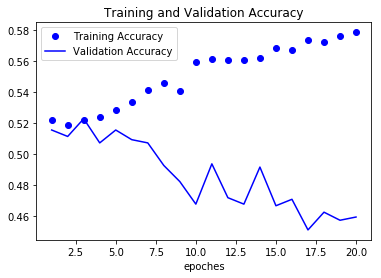

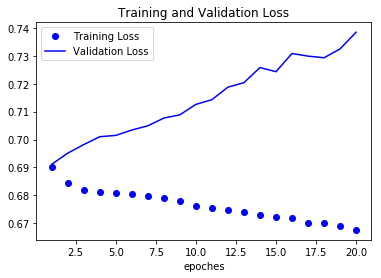

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

**Conclusion**:

- This classification does not work at all for the new data, with best accuracy being essentially equal to random guessing.